When I was on my [cross-country road trip](https://cduvallet.github.io/travel/) last year, I kept track of a lot of things in the hopes of doing amazing analyses when I got back. Turns out having a job as a data scientist makes it a lot harder to find time to do data science on the side, and so I've only really gotten a chance to look into my [expenses](2019/07/road-trip-expenses-pt1). One of the things I had really wanted to do was make a map of all the places I went, but I didn't actually know how to work with geospatial data in Python yet. I had this grand idea that I'd learn spatial data techniques while on my trip, but turns out hiking, drinking beer while watching the sunset, and going to bed early were way more compelling ways to spend my time. Luckily for me, one of the most fun parts of my new job has been learning geospatial coding and plotting techniques. I've been having fun with it in my job, and I realized taht it also means I get to finally make my map! 

In this post, I'll go over geocoding (which I've never done before!), plotting points and lines on a map, and adding a background map. I will note that I'm still very early in my geospatial analysis days and most of these coding tricks are things I've picked up in the last couple of months, so I'm sure future-me will revisit this post in a few years and cringe at some of the coding choices I've made. But who cares, I wanna make the map! Let's do it!

In [83]:
import pandas as pd
import geopandas as gpd

import contextily as ctx
import shapely

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from time import sleep # to limit geocoding rate in for loops

import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import seaborn as sns
%matplotlib inline

For this map, we'll use the dataset where I tracked my mileage. Because I am a human and not a robot, I wasn't super consistent about it and didn't always manage to get the mileage at each place I stayed at, for example. I also sometimes wrote down mileage multiple times a day, especially on days when I drove a long time. But I made up for it whenever I could, and I think I got a pretty decent coverage over the whole trip, with at least the majority of my camps tracked. Here's what the data looks like:

In [84]:
df = pd.read_excel('mileage.xlsx')
# The last two columns are extra, drop those
df = df.iloc[:, :-2]
print(df[['city', 'state']].drop_duplicates().shape)
df.head()

(69, 2)


,day,city,state,mileage,time,part
0,2019-02-17,san diego,ca,41491.0,midday,1
1,2019-02-17,sonoran desert national monument,az,41889.0,night,1
2,2019-02-18,mesa,az,41948.0,midday,1
3,2019-02-18,tucson,az,42067.0,evening,1
4,2019-02-18,indian bread rocks blm,az,42179.0,night,1


Because I tried to track my mileage every night but sometimes forgot and got it in the morning, I included a column indicating what time of day-ish that mileage occured at. That's what's in the `time` column. The `part` column on the right indicates whether it was part 1 (San Diego to Boston) or 2 (Boston to San Diego) of my road trip, and everything else is pretty self-explanatory.

## Geocoding locations

Before I can make a map, I need to get the actual locations of the places I wrote down. From some poking around, I found that the [geopy](https://geopy.readthedocs.io/) library has a wrapper for many different types of geocoders. I went ahead and tried using the one called [Nominatim](https://operations.osmfoundation.org/policies/nominatim/), because it seems to be fairly standard and doesn't require an API, but if I wanted to geocode more locations I'd be much more careful about reading up on the terms of each provider and making sure I wasn't abusing their service. But since I only have about 70 places to geolocate, I'll just stick with this one.

First, I need to set up my geolocator object. Then, I'll get just the unique cities that I wrote down in my spreadsheet, geolocate them, and put them back into my original dataframe. 

In [3]:
# Set up geolocator object
# Increase the timeout so I don't get timeout errors as much
geolocator = Nominatim(user_agent="road-trip-map", timeout=10)
# Make sure to limit requests to abide by terms
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Get the unique cities in my dataframe
cities = df[['city', 'state']].drop_duplicates()
# Convert the two columns city and state into one string
cities['to_geolocate'] = cities['city'] + ' ' + cities['state']

# Geolocate the cities - this takes a couple of minutes
cities['location'] = cities['to_geolocate'].apply(geocode)

Let's take a look at what this looks like:

In [4]:
cities.head()

,city,state,to_geolocate,location
0,san diego,ca,san diego ca,"(San Diego, San Diego County, California, Unit..."
1,sonoran desert national monument,az,sonoran desert national monument az,"(Sonoran Desert National Monument, Riggs Road,..."
2,mesa,az,mesa az,"(Mesa, Maricopa County, Arizona, United States..."
3,tucson,az,tucson az,"(Tucson, Pima County, Arizona, United States o..."
4,indian bread rocks blm,az,indian bread rocks blm az,"(Indian Bread Rocks Picnic Area, Happy Camp Ca..."


I'm super impressed at this geocoder, it even got the random BLM campground I stayed at in Arizona (Indian Bread Rocks)! I remember this one well - I was super worried about it because I'd be getting in after dark and there weren't too many backup options in this stretch of road, and the _first_ random BLM campground I'd stayed at was quite difficult to find (Google maps took me down some dirt road straight to a "no trespassing" fenced-in compound, and then when I got back on the correct dirt road I took a wrong turn and got myself into some trees. Sorry for the scratches on the car, Dad!) Anyway, this camp was way better - after some delicious tacos in Tucson, I remember that it was super easy to find and well-signed, and there was an open spot for me, a toilet, and even some cell service! I snuggled up with a beer and a funny family group chat, and when I woke up the next morning everything was covered in snow. I think it was the first morning where I truly felt like I was on a road trip, I knew what I was doing, and it was gonna be _amazing_.

All that to say, it's cool that the geocoder found it. Let's see if there are any places it couldn't find, and if I can fix those manually:

In [5]:
cities[cities['location'].isnull()]

,city,state,to_geolocate,location
6,big bend hot springs,tx,big bend hot springs tx,None
19,great smoky mountains national park,tn,great smoky mountains national park tn,None
24,mississippi river state park,tn,mississippi river state park tn,None
26,haw creek falls camp,ar,haw creek falls camp ar,None
31,lake clayton state park,nm,lake clayton state park nm,None
33,joe skeen blm campground,nm,joe skeen blm campground nm,None
38,south rim grand canyon national park,az,south rim grand canyon national park az,None
50,grand staircase escalante,ut,grand staircase escalante ut,None
55,ken's lake campground,ut,ken's lake campground ut,None
57,rabbit valley jouflas campground,ut,rabbit valley jouflas campground ut,None


Interesting, lots of campgrounds within parks here that I suppose make sense are hard to find, but others which are more surprising (e.g. "Grand Tetons National Park" -- what's going on there?). 

I'll just go through each of these one by one and try to figure out what's causing the issue. In some cases, I imagine just zooming back out to the park will be enough. I'll just try variations of each unfound string in the geocoder, and then check if the location it returns is the one I wanted. I won't include all the code with my back-and-forths here, but I will track what the problem was in the comments in the code block below:

In [6]:
# This dictionary maps "current location name": "correct location name"
fixgeolocate = {
    'big bend hot springs tx': 'big bend national park tx', # too specific
    'great smoky mountains national park tn': 'great smoky mountains national park', # the coder has this in NC
    'mississippi river state park tn': 'st francis national forest', # this place had two names, v confusing
    'haw creek falls camp ar': 'haw creek falls', # this is the one I almost got flooded in, in the Ozarks
    'lake clayton state park nm': 'clayton lake state park nm', # messed this up everytime, beautiful place tho
    'south rim grand canyon national park az': 'grand canyon national park az', # too specific
    'grand staircase escalante ut': 'Grand Staircase-Escalante National Monument', # too lazy to write it all out
    'rabbit valley jouflas campground ut': 'rabbit valley co',
    'norris junction yellowstone national park wy': 'norris geyser wy', # too specific
    'mammoth campground yellowstone national park wy': 'mammoth campground wy', 
    'old faithful yellowstone national park wy': 'old faithful wy', 
    'turpin meadow camp wy': 'turpin meadow campground wy',
    'grand tetons national park wy': 'grand teton national park wy', # typo, guess there's only one teton
    'catnip reservoir sheldon wildlife refuge nv': 'catnip reservoir nv',
    'joe skeen blm campground nm': 'BLM El Malpais',
    "ken's lake campground ut": "Ken's Lake", # camp that took forever to find outside of moab...

}


So turns out there's only one Teton in the park name (even though there are multiple mountains!). The geocoder also had trouble finding the Joe Skeen campground at El Malpais, because it's apparently got a typo in whatever database it's pulling from (it has is listed as "Jpe Skeen" womp womp). Honestly it was one of the best free campgrounds I found -- I stayed there two nights, after I unsuccessfully tried to find a spot at the much smaller (and more popular) campground at El Morro monument. Also I chuckled a bit that the geocoder couldn't find the Ken's Lake campground, because *I* also had a lot of trouble finding it! It was a campground outside of Moab, which I paid something like $20 for after driving around for _hours_ trying to find a place to camp. Note to future travellers: when it comes to Moab, book ahead!

Anyway, let's geocode these updated location and merge it back with the rest of the location results.

In [7]:
# Get location for each of these places
new_locations = {}
for key, val in fixgeolocate.items():
    # Geocode the updated location
    loc = geocode(val)
    # Build a map of old location --> geocoded location
    new_locations[key] = loc
    
    # Add a delay to not overload the geocoder
    sleep(1)

In [8]:
# And update the dataframe

# Get the indices of the rows that have "None" for the location
null_locs = cities[cities['location'].isnull()].index

# Replace the "location" value in those rows with the new location
# in the new_locations dict
cities.loc[null_locs, 'location'] = cities.loc[null_locs, 'to_geolocate'].map(new_locations)

Now that I have everything geocoded, I'll merge the locations back onto my original dataframe, which contains the day, part of the trip, and mileage.

In [9]:
# Merge geocoded locations with the original dataframe
gdf = pd.merge(
    df, cities[['city', 'state', 'location']], 
    on=['city', 'state'],
    how='left'
)
gdf.head()

,day,city,state,mileage,time,part,location
0,2019-02-17,san diego,ca,41491.0,midday,1,"(San Diego, San Diego County, California, Unit..."
1,2019-02-17,sonoran desert national monument,az,41889.0,night,1,"(Sonoran Desert National Monument, Riggs Road,..."
2,2019-02-18,mesa,az,41948.0,midday,1,"(Mesa, Maricopa County, Arizona, United States..."
3,2019-02-18,tucson,az,42067.0,evening,1,"(Tucson, Pima County, Arizona, United States o..."
4,2019-02-18,indian bread rocks blm,az,42179.0,night,1,"(Indian Bread Rocks Picnic Area, Happy Camp Ca..."


## Getting ready to plot, plus some more wrangling

Before I can plot these locations, I need to convert them to `shapely` objects and put them in the `geometry` column of the `geopandas` dataframe. I'll do this using the [points_from_xy() function in geopandas](https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html#creating-a-geodataframe-from-a-dataframe-with-coordinates), after grabbing the latitude and longitude from the locations returned by `geopy`. The [geopy `location` class](https://geopy.readthedocs.io/en/stable/#geopy.location.Location) has latitude and longitude as two properties, so it's super easy to do this!

In [10]:
# query each location's latitude and longitude
gdf['latitude'] = gdf['location'].apply(lambda x: x.latitude)
gdf['longitude'] = gdf['location'].apply(lambda x: x.longitude)

# Add the shapely Point in the 'geometry' column
gdf['geometry'] = gpd.points_from_xy(gdf['longitude'], gdf['latitude'])

# And convert the dataframe to a geopandas dataframe
gdf = gpd.GeoDataFrame(gdf)

Almost ready to plot! I want to also add an easy USA background to my plot, otherwise it'll just be points in a blank axis. Let's use some of the [built-in geopandas maps](https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html) to do this.

In [11]:
# Read in the world - this returns just a normal geodataframe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Get just the US
usa = world.query('name == "United States of America"')

Ok, _now_ I'm ready to plot where I went!

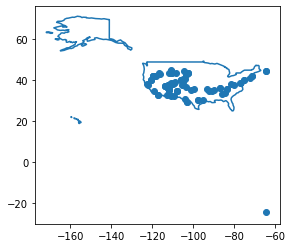

In [12]:
# Plot the USA
ax = usa.boundary.plot()
# Overlay my point locations
gdf.plot(ax=ax)

Uh oh. There's one point that's suuuper not right (and one that's in ... Canada?). Wonder what's happening here...

In [13]:
# Fix the one in the bottom right first
gdf.sort_values(by=['latitude', 'longitude']).head(1)

,day,city,state,mileage,time,part,location,latitude,longitude,geometry
27,2019-04-18,hot springs,ar,NaN,afternoon,2,"(aguas termales, La Peña Azul, Municipio de Ge...",-24.238173,-64.159278,POINT (-64.15928 -24.23817)


Ah, seems that Hot Springs, Arkansas got geocoded somewhere in Argentina... Let's fix that manually and re-plot!

In [14]:
# I manually checked that this returns the Hot Springs in Arkansas
hotsprings = geocode('hot springs')
gdf.at[27, 'location'] = hotsprings # need to use at to avoide error bc "hotsprings" is a tuple
gdf.loc[27, 'latitude'] = hotsprings.latitude
gdf.loc[27, 'longitude'] = hotsprings.longitude
# Re-code the lat/lon into a point
gdf.loc[27, 'geometry'] = shapely.geometry.Point(gdf.loc[27, 'longitude'], gdf.loc[27, 'latitude'])

In [15]:
# Fix the one in Canada next
gdf.sort_values(by=['longitude'], ascending=False).head(3)['location']

94    (Oakland, Municipality of the District of Lune...
93    (Oakland, Municipality of the District of Lune...
14    (Boston, Suffolk County, Massachusetts, United...
Name: location, dtype: object

And it found Oakland as the Oakland in Nova Scotia... Let's fix that too.

In [16]:
# I manually checked that this returns the Hot Springs in Arkansas
oakland = geocode('oakland ca usa')
for ix in [93, 94]:
    gdf.at[ix, 'location'] = oakland # need to use at to avoide error bc "hotsprings" is a tuple
    gdf.loc[ix, 'latitude'] = oakland.latitude
    gdf.loc[ix, 'longitude'] = oakland.longitude
    # Re-code the lat/lon into a point
    gdf.loc[ix, 'geometry'] = shapely.geometry.Point(gdf.loc[ix, 'longitude'], gdf.loc[ix, 'latitude'])

There's a couple other mistakes that I found after plotting, which I'll just fix here without explaining step by step:

In [17]:
def update_loc(ix, newloc):
    gdf.at[ix, 'location'] = newloc
    gdf.loc[ix, 'latitude'] = newloc.latitude
    gdf.loc[ix, 'longitude'] = newloc.longitude
    # Re-code the lat/lon into a point
    gdf.loc[ix, 'geometry'] = shapely.geometry.Point(gdf.loc[ix, 'longitude'], gdf.loc[ix, 'latitude'])

# My original Joplin campground coded somewhere in West Virginia
ix = 28
newloc = geocode('joplin campground')
update_loc(ix, newloc)

# Wyoming ('wy') got read in as "way", so these two are in the wrong place
ix = 73
newloc = geocode('sundance wyoming')
update_loc(ix, newloc)

ix = 76
newloc = geocode('cody wyoming')
update_loc(ix, newloc)

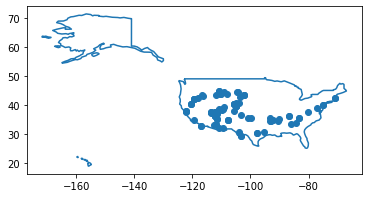

In [19]:
# Re-try plotting!
# Plot the USA
ax = usa.boundary.plot()
# Overlay my point locations
gdf.plot(ax=ax)

Yes! No more side-trips to Argentina (alas). Okay, now that I have everything set up to make this map, let's work on making it prettier! I have two main goals here, beyond simple aesthetics:

1. Add a more informative background map
2. Connect the dots with lines, showing my actual trajectory

I have a pretty good idea of how to do #1, since I've been recently playing around with [contextily](https://github.com/darribas/contextily) for adding basemaps. It was a bit of pain to install (I needed to play around with setting conda channel priorities), but now that I have it working it's extremely useful.

For #2, I'll need to do some significant wrangling with shapely to convert subsequent points into lines.

## Adding a background map

Let's start with #1! I'll first need to set the projection of my current data to the [WGS84 projection (EPSG:4326)](https://en.wikipedia.org/wiki/World_Geodetic_System), which is what latitude and longitudes are encoded in. For those of y'all not used to working with maps, projections are basically different ways of encoding 3D information (i.e. the Earth) onto a 2D space (i.e. a computer screen). You've heard of this before certainly, the [Mercator projection](https://en.wikipedia.org/wiki/Mercator_projection) is the one that makes Greenland look huge and Africa look tiny. There is lots of scholarship and internet debate on different projections, I'm sure, so I won't even start down that rabbit hole! (Though if you are gonna start down this rabbit hole, I recommend looking into how different map projections change how we view the world, and contribute to colonialism by emphasizing some geographies over others). 

Anyway. Mostly what I know is how to work with projections in order to get the maps that I need out of my code. 

In [20]:
# Set the projection to WGS84
gdf.crs = {'init': 'epsg:4326'}
# Modify projection to match what contextily uses
gdf = gdf.to_crs(epsg=3857)

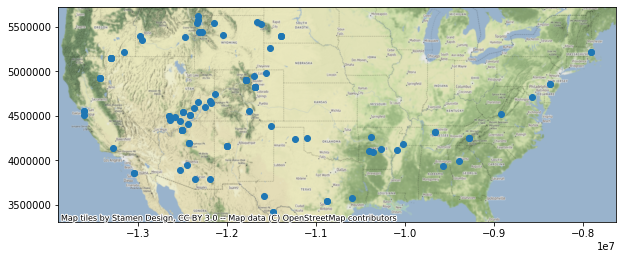

In [21]:
# Plot the points
ax = gdf.plot(figsize=(10, 5))

# Add basemap
ctx.add_basemap(ax=ax)

Wowza, our first map!! Though I'd like to have the state outlines on this map as well. It'll give some structure to the map, and also expand it to the whole US rather than just the band that I visited. From a quick google, seems that [this file](https://www.arcgis.com/home/item.html?id=f7f805eb65eb4ab787a0a3e1116ca7e5) should do the trick.

In [22]:
states = gpd.read_file('shapefiles/states.shp')
# Keep only the 50 continental states
dropstates = ['Hawaii', 'Alaska']
states = states.query('STATE_NAME != @dropstates')

# Convert states to the right projection for contextily
states = states.to_crs(epsg=3857)
states.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-13625730.016 6144404.934, -13..."
2,Montana,3,30,Mountain,MT,"POLYGON ((-12409387.580 5574754.285, -12409986..."
3,Maine,4,23,New England,ME,"MULTIPOLYGON (((-7767570.862 5476923.993, -777..."
4,North Dakota,5,38,West North Central,ND,"POLYGON ((-10990622.005 5770462.676, -11021390..."
5,South Dakota,6,46,West North Central,SD,"POLYGON ((-11442350.599 5311256.999, -11466561..."


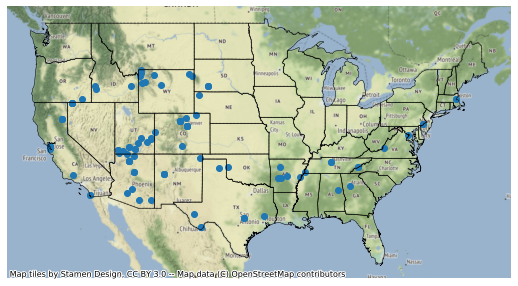

In [23]:
# Re-plot everything, adding on the state outlines
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the outlines
states.boundary.plot(color='black', linewidth=0.5, ax=ax)

# Plot the points
gdf.plot(ax=ax)

# Add basemap
ctx.add_basemap(ax=ax)

# Remove axes
ax.set_axis_off()

Ah! There it is!!! It's my road trip!!!

Okay, before I dive into making trajectories, can I just color each point by their day on my trip? I sometimes have multiple entries per day, so I'll need to create a map from day to number. I'll just increment each day that I wrote down, regardless of whether they're consecutive days or not. Since I'm just going to visualize the day using colors, all I care about is the relative days. 

In [87]:
gdf = gdf.sort_values(by='day')

days = gdf['day'].unique()
daysdict = dict(zip(days, range(len(days))))

# Use dict to map into column
gdf['day_number'] = gdf['day'].map(daysdict)

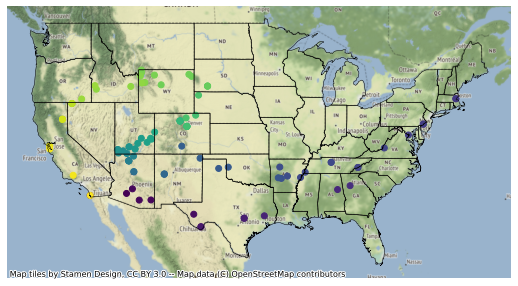

In [88]:
# Re-plot everything, adding on the state outlines
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the outlines
states.boundary.plot(color='black', linewidth=0.5, ax=ax)

# Plot the points
gdf.plot(ax=ax, column='day_number')

# Add basemap
ctx.add_basemap(ax=ax)

# Remove axes
ax.set_axis_off()

## Converting points to trajectories

Ok, now to convert these points into actual lines corresponding to my travels. I'll make two lines: one for the first part of my trip (San Diego to Boston), and one for the second (Boston to San Diego, with lots of fun detours in between).

First, I need to sort my trip by day. Because on some days I wrote down multiple mileages, I also need to sort by time of day. I'll do this by setting my `time` column as an ordered categorical, since I only tracked the rough time of day (i.e. "morning" and "night").

In [90]:
# Set the column as categorical type
gdf['time'] = gdf['time'].astype('category')
# Manually specify the order
order = ['morning', 'midday', 'afternoon', 'evening', 'night', 'allday']

# Set categories as ordered dtype
gdf['time'].cat.set_categories(order, ordered=True, inplace=True)
gdf['time'].head()

0     midday
1      night
2     midday
3    evening
4      night
Name: time, dtype: category
Categories (6, object): [morning < midday < afternoon < evening < night < allday]

You can see above that the data type of this column is now a category, ordered like this: `[morning < midday < afternoon < evening < night < allday]`.

Now, let's convert all of my points into two lines corresponding to the two parts of the trip:

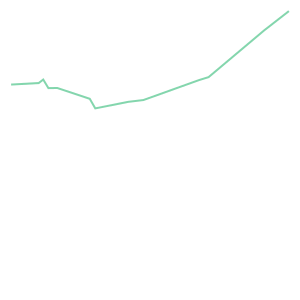

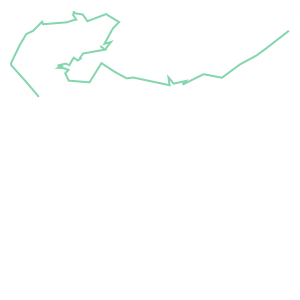

In [91]:
# Get line of first part of trip
part1 = shapely.geometry.LineString(
    gdf.query('part == 1').sort_values(by=['day', 'time'])['geometry'].values
)
display(part1)

part2 = shapely.geometry.LineString(
    gdf.query('part == 2').sort_values(by=['day', 'time'])['geometry'].values
)

display(part2)

Wow, that was easier than I thought! Now, let's figure out how to overlay these lines onto my map.

In [28]:
# Make a geodataframe with the two parts of my trip
linegdf = gpd.GeoDataFrame(
    {'geometry': [part1, part2],
     'trip_part': ['part1', 'part2']}
)

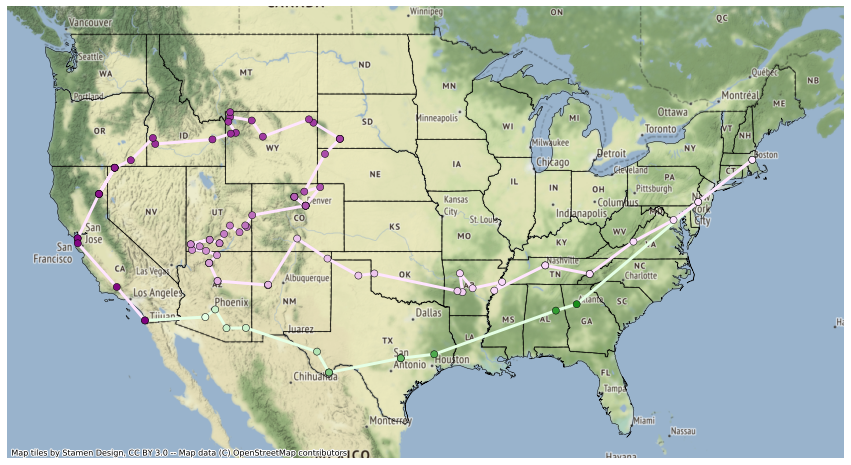

In [92]:
# Make the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the state outlines
states.boundary.plot(color='black', linewidth=0.5, ax=ax)

## Plot Part 1 of the trip

# I'm getting an error when I pass in the tuple, not sure why
c = to_hex(sns.light_palette('green')[0])

# Plot line
linegdf.query('trip_part == "part1"').plot(
    color=c, 
    linewidth=3,
    ax=ax
)

# Plot points colored by day
gdf.query('part == 1').plot(
    column='day_number', 
    cmap=sns.light_palette('green', as_cmap=True),
    ax=ax,
    markersize=50,
    edgecolor='black', linewidth=0.5,
    zorder=1000 # force the points to be the top layer of the plot
)

## Part 2
c = to_hex(sns.light_palette('purple')[0])

# Plot line
linegdf.query('trip_part == "part2"').plot(
    color=c, 
    linewidth=3,
    ax=ax
)

# Plot points colored by day
gdf.query('part == 2').plot(
    column='day_number', 
    cmap=sns.light_palette('purple', as_cmap=True),
    ax=ax,
    markersize=50,
    edgecolor='black', linewidth=0.5,
    zorder=1000 # force the points to be the top layer of the plot
)

# Add basemap
ctx.add_basemap(ax=ax)

# Remove axes
ax.set_axis_off()

Ah it's so beautiful!! Let me tell you a little bit more about what you're seeing:

For the first part of my trip, I went from San Diego to Austin in about a week. Then, I headed to New Orleans to meet Ben, and we drove from New Orleans to Atlanta (I did a bad job of tracking things during this time). Then, through a comical series of events, we ended up driving back to Boston from Atlanta in about two days. You can see the straight shot from Georgia to Pennsylvania, which is that part (we stayed with his sister in Philly as our one stop).

In Part 2, Ben and I drove straight down to Nashville (with the Philly pit stop again, thanks Micah!) I went to Ithaca for a [hackathon](https://cduvallet.github.io/mbiome-data-viz/) (not shown here, because I flew and therefore accrued zero mileage) and Ben went back to Boston. Then I headed to Memphis for an amazing dinner with live music, and then made my way West to Utah. The little spike you see in Arkansas was when I tried to go to the Ozarks, but it was raining (and I had to drive through at least 6 inches of water to get out of my campground oops), so I made last-minute changes and headed to Hot Springs to have a nice soak. Similarly, the upshot into Colorado after Texas was when I realized that Great Sand Dunes National Park was actually not a huge detour from my current path, and that I wouldn't have another good time to go there. Then I headed down to El Malpais (awesome place), Flagstaff to see the [QIIME 2](https://qiime2.org/) team, and then up to the best two weeks of my trip: the national lands bonanza that is northern Arizona and Utah. You can see how my trajectory went north to the Grand Canyon, then east to get around the canyon and back west to hit Zion. Then I made my way through amazing Utah, through Bryce and Grand Staircase Escalante, until I finally headed to Denver to meet up with Ben. Denver has a lot of back-and-forth: Ben and I went into the mountains for the weekend and then came back to Denver, and I also had to spend an extra day in town to watch Nathaniel's defense and figure out some job stuff (after spending the night in the prairie about two hours away). Then I headed up to Badlands in South Dakota, Yellowstone in Wyoming, and met up with Janyne and some friends in Nevada Catnip Reservoir. After that, the home stretch was just California: Susanville with Janyne, SF with Jeremy and my brothers, and finally back down to San Diego. 

It's awesome how looking at this map makes it so easy to remember each little part of my trip! I love it. :D

I'm going to go ahead and post this map as-is, even though there's lots of ways I'd want to improve it. For example, I'd love to be able to see more clearly what day each part of the trip corresponded to, since there were some days wehre I drove _huge_ distances and others when I got to stay and play where I was. Maybe I'll try to cross-reference this map with my spreadsheet where I tracked the camps I stayed at. Or perhaps I'll do the manual work of geocoding the camps directly, but that is a bit more work than here because I wasn't very specific (e.g. when I stayed at my friend Jettie's house in Austin, I wrote down "Jettie's house" - which I really hope the geocoder won't be able to find!)

Also, maybe the next step on this map is to make it interactive... I've recently learned about [folium](https://python-visualization.github.io/folium/), which seems to be a super easy way to make interactive maps. Hopefully I find time to give it a go!

